<a href="https://colab.research.google.com/github/calebmckay1/DS-Unit-1-Sprint-2-Statistics/blob/master/module2/LS_DS_122_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

column_headers = ['Class Name','handicapped-infants','water-project-cost-sharing',
                   'adoption-of-the-budget-resolution','physician-fee-freeze',
                   'el-salvador-aid','religious-groups-in-schools',
                   'anti-satellite-test-ban','aid-to-nicaraguan-contras',
                   'mx-missile','immigration','synfuels-corporation-cutback',
                   'education-spending','superfund-right-to-sue','crime',
                   'duty-free-exports','export-administration-act-south-africa']

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data',
                 names= column_headers)

# loaded dataset and imported some tools

In [0]:
df = df.replace({'y':1, 'n':0, '?': np.NaN})

# replaced ? with NaNs

In [0]:
rep = df[df['Class Name'] == 'republican']
# sorted via party

In [6]:
policy = rep.drop('Class Name', axis=1)
policy.columns
# removed the first column since it was a string and would interfer
# in the future.

Index(['handicapped-infants', 'water-project-cost-sharing',
       'adoption-of-the-budget-resolution', 'physician-fee-freeze',
       'el-salvador-aid', 'religious-groups-in-schools',
       'anti-satellite-test-ban', 'aid-to-nicaraguan-contras', 'mx-missile',
       'immigration', 'synfuels-corporation-cutback', 'education-spending',
       'superfund-right-to-sue', 'crime', 'duty-free-exports',
       'export-administration-act-south-africa'],
      dtype='object')

In [0]:
from scipy import stats

def c (data, confidence=0.95):
  data = np.array(data)
  x_bar = np.mean(data)
  n = len(data)
  s = np.std(data, ddof=1)
  std_err = s / np.sqrt(n)
  t = stats.t.ppf((1 + confidence) / 2.0, n - 1)
  margin_of_error = t*std_err
  lower_bound = x_bar - margin_of_error
  upper_bound = x_bar + margin_of_error
  return (lower_bound, x_bar, upper_bound)

# imported stats, and created a function called "c".

# got help from the Q&A but still confused on how the function works. I understand
# how to input but not sure how it was created. Most confusing part is the "data"
# like where does it come from. Although it looks like its just defined as 
# the dataframe and turned into a numpy array

# had to run this code in order to properly run the below cell, the creation
# of this function is still confusing to me but I think I'll get it with more
# and more exposure.

In [15]:
cintervals = []

for headers in policy.columns:
  cleaned = policy[headers].dropna()
  cintervals.append(c(cleaned))

cintervals

# created new dataframe called 'cintervals' and added the data to the 
# empty dataframe 'cintervals' using a for loop combined with the previously
# created function 'c' and the append function.

[(0.12765166444807918, 0.18787878787878787, 0.24810591130949655),
 (0.42526571045979167, 0.5067567567567568, 0.5882478030537219),
 (0.08143520131697565, 0.13414634146341464, 0.18685748160985363),
 (0.9710067448304756, 0.9878787878787879, 1.0047508309271003),
 (0.9183979451371699, 0.9515151515151515, 0.9846323578931332),
 (0.850987486003394, 0.8975903614457831, 0.9441932368881721),
 (0.17420089269707362, 0.24074074074074073, 0.30728058878440784),
 (0.09595477158126557, 0.15286624203821655, 0.20977771249516752),
 (0.06593485907282265, 0.11515151515151516, 0.16436817123020767),
 (0.4809959592103161, 0.5575757575757576, 0.6341555559411991),
 (0.0788755652396695, 0.1320754716981132, 0.18527537815655692),
 (0.8176017935029393, 0.8709677419354839, 0.9243336903680285),
 (0.8061858971620528, 0.8607594936708861, 0.9153330901797194),
 (0.960253517544598, 0.9813664596273292, 1.0024794017100602),
 (0.044394355010013827, 0.08974358974358974, 0.13509282447716567),
 (0.5796460416043707, 0.657534246575

In [16]:
ci = pd.DataFrame(cintervals)
ci.columns = ['lower', 'mean', 'upper']
ci['moe']  = ci['upper'] - ci['mean'] 
ci.head(16)

# this makes sens to me, just created headers, and a dataframe using the 
# previous data from cintervals dataframe, and using upper minus mean to get
# the margin of error. 

# So is this all I need to do to generate and numerically represent a confidence 
# interval stated in part one of assignment?

,lower,mean,upper,moe
0,0.127652,0.187879,0.248106,0.060227
1,0.425266,0.506757,0.588248,0.081491
2,0.081435,0.134146,0.186857,0.052711
3,0.971007,0.987879,1.004751,0.016872
4,0.918398,0.951515,0.984632,0.033117
5,0.850987,0.897590,0.944193,0.046603
6,0.174201,0.240741,0.307281,0.066540
7,0.095955,0.152866,0.209778,0.056911
8,0.065935,0.115152,0.164368,0.049217
9,0.480996,0.557576,0.634156,0.076580


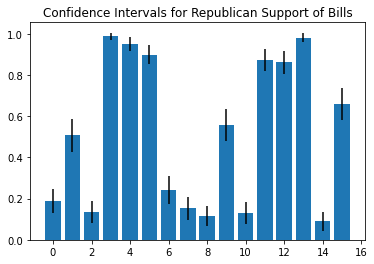

In [19]:
plt.bar(x=range(0,16,1), height=ci['mean'], yerr=ci['moe'])
plt.title("Confidence Intervals for Republican Support of Bills")
plt.show();

# so it seems like the confidence intervals help kind of predict what the overall
# population is from the sample size, like a new republican would probably support
# the bill 13.

# this portion I understand how to do and kind of the purpose, to visualize. 

In [0]:
# it doesn't look like it's normal distribution.

In [171]:
column_headers = ['age','workclass','f','education','ed-num','mstatus',
                  'occupation','relationship','race','sex','cap-gain',
                  'cap-loss','hours-week','native-country', 'income']

adf = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
                  names=column_headers, na_values='?')

adf

,age,workclass,f,education,ed-num,mstatus,occupation,relationship,race,sex,cap-gain,cap-loss,hours-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


Chi-squared tests:
Take a dataset that we have used in the past in class that has categorical variables. Pick two of those categorical variables and run a chi-squared tests on that data
By hand using Numpy
In a single line using Scipy

In [0]:
# null hypothesis, there is no relationship between race and sex in census response
# alternative hypothesis, there is a relationship race and sex
# confidence level 95%

In [172]:
rsdf = adf[['hours-week','sex']]
rsdf['hours-week'].value_counts()

40    15217
50     2819
45     1824
60     1475
35     1297
      ...  
92        1
94        1
87        1
74        1
82        1
Name: hours-week, Length: 94, dtype: int64

In [173]:
rsdf = pd.crosstab(adf['hours-week'],adf['sex'], margins=True)
rsdf

sex,Female,Male,All
hours-week,,,
1,10,10,20
2,14,18,32
3,14,25,39
4,32,22,54
5,32,28,60
...,...,...,...
96,0,5,5
97,0,2,2
98,0,11,11


In [170]:
# expected value of females who worked 5 hours per week
# row total * column total / total observation
10771*60/32561

19.847670526089495

In [0]:
# more females worked 5 hours per week than expected. 

In [197]:
all_hours = rsdf.iloc[0:-1, 2:].values
all_hours = all_hours.T[0]

all_hours.shape

(94,)

In [175]:
all_sex = rsdf.iloc[-1:, 0:2].values
all_sex = all_sex[0]

all_sex

array([10771, 21790])

In [189]:
total = adf.shape[0]

total

32561

In [198]:
ev = []
for i in range(len(all_hours)):
  ec = []
  for sex in all_sex:
    expected_val = sex*all_hours[i]/total
    ec.append(expected_val)
  ev.append(ec)

ev = np.array(ev)
print(ev.shape)  

(94, 2)


In [193]:
contingency = pd.crosstab(adf['hours-week'],adf['sex'])
contingency.shape

(94, 2)

In [200]:
chi2 = ((contingency - ev)**2 / ev).sum().sum()

chi2

# ran it by hand. got 2546

2546.571725831992

In [201]:
from scipy import stats

chi2, p_value, freedom, expected = stats.chi2_contingency(contingency)

print(chi2)
print(p_value)
print(freedom)

# (94-1)*(2-1) = 93*1 = 93

2546.571725831992
0.0
93


In [0]:
# due to high chi2 value of 2546 and pvalue of 0, I reject the null
# hypothesis that hours worked per week and sex are indepedant.

In [214]:
test = adf[['hours-week','sex']]
test['hours-week'].value_counts().nlargest()

40    15217
50     2819
45     1824
60     1475
35     1297
Name: hours-week, dtype: int64

In [220]:
rsdf[39:51]
# it does seem like males make up the majority of 40hrs, 45hrs, and 50hrs per week
# so sex seems to be correlated with amount of hours per week, just like the 
# chi*2 showed.

sex,Female,Male,All
hours-week,,,
40,4922,10295,15217
41,9,27,36
42,60,159,219
43,57,94,151
44,47,165,212
45,392,1432,1824
46,24,58,82
47,12,37,49
48,108,409,517


In [0]:
# t test, chi squared test, confidence test

## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)